In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amex-parquet/test_data.parquet
/kaggle/input/amex-parquet/train_data.parquet


Our goal is to use this industrial scale dataset to predict the probability that a customer will default in the future. Eighteen months of profile data is stored for each customer previous their most recent credit card statement. If they do not pay this amount within 120 days of the statement it is considered a default.




# Exploratory Data Analysis

The data was converted from .csv to .parquet to enable quick loading into pandas within our 16gb RAM environment. 

<br />Now we preview the data.

In [2]:
import pandas as pd

df=pd.read_parquet('/kaggle/input/amex-parquet/train_data.parquet')
print(df.shape)
df.head()

(5531451, 191)


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


Wow! We have over 5.5 million rows and 190 columns. Our column names are anonymized but fall into these categories: 
 <br />D_* = Delinquency variables
 <br />S_* = Spend variables
 <br />P_* = Payment variables
 <br />B_* = Balance variables
 <br />R_* = Risk variables
 <br />
 <br />
The size of the data is too large for our hardware. Let's remove the data we percieve to be less relevant. 

We note the customer ID and the date columns. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: float32(185), int64(2), object(4)
memory usage: 4.1+ GB


There are four non-numeric data types. Let's convert these so we may apply a logistic regression model.

Let's plot our columns.

In [4]:
"""hist = df.hist(bins=50, figsize = (40,200), layout=(-1,4) )"""

'hist = df.hist(bins=50, figsize = (40,200), layout=(-1,4) )'

# **Data Cleaning**

Let's find and remove the columns with a significant amount of NaN values. Without knowledge on the contents of each column we will remove the columns that are likely less useful.

In [5]:
temp = [column for column in df.columns if df[column].isnull().sum()/len(df) >= 0.9]
df.drop(temp, axis=1, inplace=True)

print(df.shape)

(5531451, 173)


Great! We got rid of 18 columns that contained >90% null values. 

We choose to impute by filling customer data from other months.

In [6]:
"""df=df.set_index(['customer_ID'])
df.head(n=20)
#forward fill and back fill just putting random other customers data into their adjacent rows?"""

"df=df.set_index(['customer_ID'])\ndf.head(n=20)\n#forward fill and back fill just putting random other customers data into their adjacent rows?"

In [7]:
temp = df.shape
df=df.set_index(['customer_ID'])
df=df.ffill()
df=df.bfill()
df=df.reset_index()

df=df.groupby('customer_ID').tail(1)
df=df.set_index(['customer_ID'])

#Drop date column since it
df.drop(['S_2'],axis=1,inplace=True)

print(temp, df.shape)


temp = [column for column in df.columns if df[column].isnull().sum()/len(df) >0]
print(len(temp))

(5531451, 173) (458913, 171)
0


In [8]:
df.head(n=15)

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_133,R_28,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,0.152932,0.525600,...,0.006210,0.002715,0.007186,0.004234,0.005086,0.141214,0.005810,0.002970,0.008533,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,0.152932,0.060646,...,0.002996,0.001701,0.002980,0.007479,0.007870,0.141214,0.003284,0.003169,0.008514,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.880875,0.009704,0.004284,0.812649,0.006450,0.165509,0.003796,0.007196,0.152932,0.060646,...,0.009881,0.007691,0.007383,0.006623,0.000964,0.141214,0.002202,0.000834,0.003444,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.621776,0.001083,0.012564,1.006183,0.007829,0.287766,0.004532,0.009937,0.152932,0.046104,...,0.001789,0.005140,0.002704,0.006184,0.001899,0.141214,0.008183,0.005560,0.002983,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.871900,0.005573,0.007679,0.815746,0.001247,0.176403,0.000231,0.005528,0.152932,0.044671,...,0.005045,0.003706,0.002974,0.004162,0.005764,0.141214,0.008154,0.006944,0.000905,0
000084e5023181993c2e1b665ac88dbb1ce9ef621ec5370150fc2f8bdca6202c,0.824061,0.009776,0.007853,1.001713,0.006885,0.395740,0.002855,0.006134,0.152932,0.013881,...,0.002709,0.002873,0.009401,0.007832,0.000957,0.141214,0.009054,0.006943,0.001446,0
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4,0.477116,0.000467,0.009413,1.009217,0.007775,0.267037,0.006128,0.125927,0.132976,0.057729,...,0.001976,0.003672,0.006010,0.005221,0.000937,0.141214,0.009790,0.003703,0.006274,0
0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4cb59b50fec59e0b6381,1.009762,0.006181,-0.000886,1.006692,0.006112,0.116401,0.000824,0.149496,0.132976,0.014716,...,0.006115,0.009657,0.002262,0.005217,0.002153,0.141214,0.001170,0.003350,0.000675,0
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85,0.424624,0.531173,0.979303,0.029291,0.008500,0.152608,0.005344,1.155846,0.132976,0.028677,...,0.009832,0.003794,1.001303,0.007061,0.876028,0.184614,1.005212,0.003350,0.734467,1


This magically removes all missing data... ??

Lets separate our labels from our dataset.

In [9]:
df_label = df.iloc[:,len(df.columns)-1]
df = df.iloc[:,0:len(df.columns)-1]
print(df_label.sum()/len(df_label))

0.2589336105100531


Our train data contains ~25% positive cases but the negative class was subsampled at 5%

We aim to remove data columns that have too high a correlation.

In [10]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
import numpy as np
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find and drop columns with high correl
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df.drop(to_drop, axis=1, inplace=True)

print(len(to_drop),df.shape)

14 (458913, 156)


##### To further reduce the degrees of freedom we remove columns with low variance

In [11]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

temp = df.drop(['D_63', 'D_64'], axis=1)

# Initialize and fit the method
vt = VarianceThreshold(threshold = float(0.1))
vt.fit(temp)

#columns with sufficient variance
keep = list(compress(temp.columns, vt.get_support()))

#dropped = ['D_63', 'D_64', 'customer_ID', 'S_2']

keep.extend(['D_63', 'D_64',])

#keep = keep + dropped
#keep.append('D_64')
df=df[keep]
keep.extend([ 'customer_ID', 'S_2'])
#keep.append('customer_ID')
#keep.append('S_2')
len(keep)

58

Now lets take a look at our data types.

In [12]:
print(df.dtypes.value_counts())
print(df.columns)
#how to find categorical data encoded as numeric

float32    54
object      2
dtype: int64
Index(['D_39', 'B_2', 'B_5', 'D_48', 'B_6', 'B_8', 'D_50', 'B_10', 'S_5',
       'S_6', 'B_12', 'R_5', 'D_60', 'D_61', 'D_65', 'B_16', 'B_17', 'B_18',
       'B_20', 'D_68', 'R_6', 'B_21', 'D_69', 'D_71', 'P_4', 'B_24', 'R_7',
       'B_26', 'D_78', 'R_8', 'S_16', 'R_10', 'D_81', 'R_14', 'D_84', 'B_30',
       'R_20', 'S_22', 'S_23', 'S_26', 'D_103', 'R_27', 'B_38', 'D_112',
       'B_40', 'S_27', 'D_114', 'D_117', 'D_120', 'D_126', 'D_128', 'D_129',
       'D_130', 'D_139', 'D_63', 'D_64'],
      dtype='object')


Convert our object columns to numeric via one hot encoding

In [13]:
df = pd.get_dummies(df)
print(df['D_64_-1'].sum())
df.drop(['D_64_-1'], axis=1, inplace = True)
print(df.shape)

1865
(458913, 63)


In [14]:
#Handling missing values
#from sklearn.impute import SimpleImputer
#my_imputer = SimpleImputer()
#df1.iloc[:,:] = my_imputer.fit_transform(df1.iloc[:,:])

We scale our data for better results

Reshaping data for model training

In [15]:
from sklearn.model_selection import train_test_split

x = df.iloc[:, :]
y = df_label.iloc[:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=23)

In [16]:
"""#does this actually help log regr sig?
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)"""

'#does this actually help log regr sig?\nfrom sklearn import preprocessing\n\nscaler = preprocessing.StandardScaler().fit(X)\nX_scaled = scaler.transform(X)'

# Model Building

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score                         
from sklearn.metrics import recall_score
# create object for the class
log = LogisticRegression(random_state=12, penalty='l2', class_weight = {0:.05, 1:.95})
log.fit(x_train, y_train) 
y_pred = log.predict(x_test)

print(np.sum(y_pred))
print(log.score(x_test, y_test))
print('\nLogistics Regression Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))


print('\nLogistics Regression Precision: {:.3f}'.format(precision_score (y_test, y_pred)))


print('\nLogistics Regression Recall: {:.3f}'.format(recall_score (y_test, y_pred)))


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


58601
0.7373114033940852

Logistics Regression Accuracy: 0.737

Logistics Regression Precision: 0.497

Logistics Regression Recall: 0.979


# Results

Accuracy: 0.737
0.8157807034258903


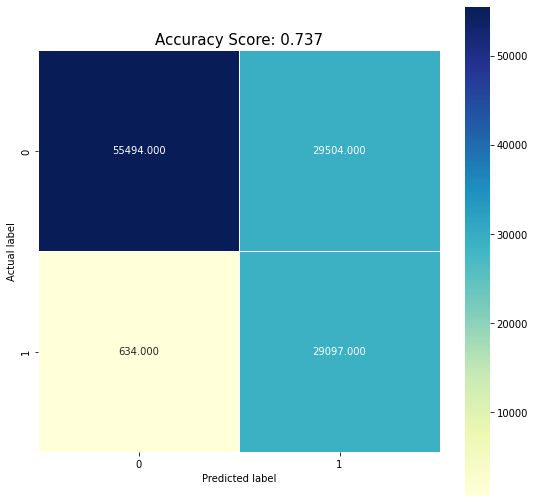

In [18]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'YlGnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(log.score(x_test, y_test),3))
plt.title(all_sample_title, size = 15);

print('Accuracy:',round(metrics.accuracy_score(y_test, y_pred),3))
metrics.roc_curve(y_test, y_pred)
print(metrics.roc_auc_score(y_test, y_pred))

In [19]:
"""
#trying random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestClassifier(n_estimators=400, max_features='sqrt', bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_jobs=-1)
#rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=1, n_jobs = -1)
# Fit the random search model
model.fit(X,Y)"""

"\n#trying random forest\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import RandomizedSearchCV, GridSearchCV\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n        

In [20]:
"""Y_pred = model.predict_proba(X)
Y_pred = Y_pred[:,1]
print(Y_pred.shape, Y_pred[25:50])"""

'Y_pred = model.predict_proba(X)\nY_pred = Y_pred[:,1]\nprint(Y_pred.shape, Y_pred[25:50])'

In [21]:
import gc
#free up ram
del df
gc.collect()

4870

In [22]:
print(len(keep), keep)

58 ['D_39', 'B_2', 'B_5', 'D_48', 'B_6', 'B_8', 'D_50', 'B_10', 'S_5', 'S_6', 'B_12', 'R_5', 'D_60', 'D_61', 'D_65', 'B_16', 'B_17', 'B_18', 'B_20', 'D_68', 'R_6', 'B_21', 'D_69', 'D_71', 'P_4', 'B_24', 'R_7', 'B_26', 'D_78', 'R_8', 'S_16', 'R_10', 'D_81', 'R_14', 'D_84', 'B_30', 'R_20', 'S_22', 'S_23', 'S_26', 'D_103', 'R_27', 'B_38', 'D_112', 'B_40', 'S_27', 'D_114', 'D_117', 'D_120', 'D_126', 'D_128', 'D_129', 'D_130', 'D_139', 'D_63', 'D_64', 'customer_ID', 'S_2']


In [23]:
#run prediction on test dat
#only loading columns that model utilizes
df2=pd.read_parquet('/kaggle/input/amex-parquet/test_data.parquet', columns =keep)
print(df2.shape)

(11363762, 58)


In [24]:
#Handling missing values via imputation
#df2.iloc[:,:] = my_imputer.fit_transform(df2.iloc[:,:])

In [25]:
#using only most recent transaction from each customer
#Does this make sense for test data??
temp = df2.shape
df2=df2.set_index(['customer_ID'])
df2=df2.ffill()
df2=df2.bfill()
df2=df2.reset_index()

df2=df2.groupby('customer_ID').tail(1)
df2=df2.set_index(['customer_ID'])

#Drop date column since it is no longer useful
df2.drop(['S_2'],axis=1,inplace=True)

print(temp, df2.shape)

#inspecting NaN
print('Columns left with NaN:')
for i in range(len(df2.columns)):
    if (df2.iloc[:,i].isnull().sum()/len(df2) > 0):
        print(df2.columns[i], round(df2.iloc[:,i].isnull().sum()/len(df2),2))

(11363762, 58) (924621, 56)
Columns left with NaN:


In [26]:
#one hot encoding
df2 = pd.get_dummies(df2)

In [27]:
from sklearn import preprocessing

X2 = df2.iloc[:, :].values.reshape(-1, len(df2.columns))
#scaler = preprocessing.StandardScaler().fit(X2)
#X2 = scaler.transform(X2)


Y_pred2 = log.predict(X2)
print(Y_pred2)

df2 = df2.reset_index()

final = pd.DataFrame({"customer_ID":df2.customer_ID,"prediction":Y_pred2})

final.to_csv('submission.csv', index=False)
print(Y_pred2, np.sum(Y_pred2))

#initial score ended as ~50 w/o scaler

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


[1 0 1 ... 1 1 1]
[1 0 1 ... 1 1 1] 467490


In [28]:
"""Y_pred2 = model.predict_proba(df2)
Y_pred2 = Y_pred2[:,1]
df2 = df2.reset_index()
print(Y_pred2, np.sum(Y_pred2))
final = pd.DataFrame({"customer_ID":df2.customer_ID,"prediction":Y_pred2})
print(final)"""

'Y_pred2 = model.predict_proba(df2)\nY_pred2 = Y_pred2[:,1]\ndf2 = df2.reset_index()\nprint(Y_pred2, np.sum(Y_pred2))\nfinal = pd.DataFrame({"customer_ID":df2.customer_ID,"prediction":Y_pred2})\nprint(final)'

In [29]:
final.to_csv('submission.csv', index=False)
print(final)

                                              customer_ID  prediction
0       00000469ba478561f23a92a868bd366de6f6527a684c9a...           1
1       00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...           0
2       0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...           1
3       00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...           1
4       00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...           1
...                                                   ...         ...
924616  ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...           0
924617  ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...           1
924618  ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...           1
924619  ffffddef1fc3643ea179c93245b68dca0f36941cd83977...           1
924620  fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...           1

[924621 rows x 2 columns]
